In [1]:
import torch
from sklearn.metrics import mean_squared_error
from sbi.analysis import pairplot
from sbi.inference import NPE
from sbi.utils import BoxUniform
from sbi.utils.user_input_checks import (
    check_sbi_inputs,
    process_prior,
    process_simulator,
)
from sbi.inference.potentials import posterior_estimator_based_potential
from sbi.samplers.rejection import rejection
from sbi.utils.user_input_checks import process_prior as sbi_process_prior


from simglucose.simulation.env import T1DSimEnv
from simglucose.controller.basal_bolus_ctrller import BBController
from simglucose.sensor.cgm import CGMSensor
from simglucose.actuator.pump import InsulinPump
from simglucose.patient.t1dpatient import T1DPatient
from simglucose.simulation.scenario_gen import RandomScenario
from simglucose.simulation.scenario import CustomScenario
from simglucose.simulation.sim_engine import SimObj, sim, batch_sim
from datetime import timedelta
from datetime import datetime
from torch.distributions import Distribution 

import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from copy import deepcopy
import time
from torch.distributions import MultivariateNormal
from dataclasses import dataclass, fields, field

from sbi.inference import NPE
from sbi.utils import RestrictedPrior, get_density_thresholder

c:\Users\320264407\Glucose-Project\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
WARNING (pytensor.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (pytensor.configdefaults): g++ not detected!  PyTensor will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set PyTensor flags cxx to an empty string.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
print(torch.__version__)
print(torch.cuda.is_available())
if torch.cuda.is_available():
    print('CUDA available')
    print(torch.cuda.get_device_name(0))
    device = torch.device('cuda')   
    print(device)

2.6.0+cu126
True
CUDA available
NVIDIA RTX A1000 6GB Laptop GPU
cuda


In [3]:
pathos = True
try:
    from pathos.multiprocessing import ProcessPool as Pool
except ImportError:
    print('You could install pathos to enable parallel simulation.')
    pathos = False

In [4]:
@dataclass
class ParamPriors:
    kmax: tuple = (0.01, 0.1)
    kmin: tuple = (0.0, 0.05)
    b: tuple = (0.5, 1.0)
    d: tuple = (0.05, 0.5)
    kabs: tuple = (0.01, 1.5)
    kp1: tuple = (3.0, 12.0)
    kp2: tuple = (0.0, 0.05)
    kp3: tuple = (0.0, 0.05)
    k1: tuple = (0.01, 0.2)
    k2: tuple = (0.01, 0.5)
    Vm0: tuple = (1.0, 15.0)
    Vmx: tuple = (0.01, 0.2)
    ka1: tuple = (0.001, 0.01)
    ka2: tuple = (0.01, 0.05)
    m1: tuple = (0.1, 0.5)
    m2: tuple = (0.1, 0.5)
    m30: tuple = (0.1, 1.0)
    m4: tuple = (0.05, 0.2)
    ki: tuple = (0.0, 0.05)
    p2u: tuple = (0.01, 0.1)
    Ib: tuple = (80.0, 140.0)
    kd: tuple = (0.01, 0.03)
    ksc: tuple = (0.05, 0.2)
print('n_params = ', len(fields(ParamPriors)))

n_params =  23


In [5]:
def get_patient_params(env):
    param_names = [f.name for f in fields(ParamPriors)]
    params = [getattr(env.env.patient._params, param) for param in param_names]
    return dict(zip(param_names, params))

In [6]:
@dataclass
class DeafultSimulationEnv:
   patient_name: str = 'adolescent#001'
   sensor_name: str = 'Dexcom'
   pump_name: str = 'Insulet'
   scenario: list[tuple[int,int]] = field(default_factory=lambda: [(7, 45), (12, 70), (16, 15), (18, 80), (23, 10)])
   hours: int = 24  # hours to simulate

In [7]:
priors = ParamPriors()

priors = ParamPriors()

# get the names and default values of the parameters using fields
param_names = [field.name for field in fields(priors)]
param_values = [field.default for field in fields(priors)]

print(param_names)
print(param_values)

['kmax', 'kmin', 'b', 'd', 'kabs', 'kp1', 'kp2', 'kp3', 'k1', 'k2', 'Vm0', 'Vmx', 'ka1', 'ka2', 'm1', 'm2', 'm30', 'm4', 'ki', 'p2u', 'Ib', 'kd', 'ksc']
[(0.01, 0.1), (0.0, 0.05), (0.5, 1.0), (0.05, 0.5), (0.01, 1.5), (3.0, 12.0), (0.0, 0.05), (0.0, 0.05), (0.01, 0.2), (0.01, 0.5), (1.0, 15.0), (0.01, 0.2), (0.001, 0.01), (0.01, 0.05), (0.1, 0.5), (0.1, 0.5), (0.1, 1.0), (0.05, 0.2), (0.0, 0.05), (0.01, 0.1), (80.0, 140.0), (0.01, 0.03), (0.05, 0.2)]


In [8]:
def process_uniform_priors(priors: ParamPriors) -> Distribution:
    """
    Create a single 23-dimensional Uniform prior:
        BoxUniform(low=(..., ..., ...), high=(..., ..., ...))
    """
    # 1) Gather lower and upper bounds
    low_vals = []
    high_vals = []
    for f in fields(priors):
        low, high = f.default  # e.g. (0.01, 0.1)
        low_vals.append(low)
        high_vals.append(high)

    # 2) Convert to Torch tensors on the GPU (if available)
    low_tensor = torch.tensor(low_vals, dtype=torch.float32, device=device)
    high_tensor = torch.tensor(high_vals, dtype=torch.float32, device=device)

    # 3) Create a single 23D BoxUniform distribution
    return BoxUniform(low=low_tensor, high=high_tensor, device=device)


In [9]:
processed_priors = process_uniform_priors(priors)
print(processed_priors)

BoxUniform(Uniform(low: torch.Size([23]), high: torch.Size([23])), 1)


In [10]:
prior_sample = processed_priors.sample(sample_shape=(1,))

In [11]:
print(prior_sample)

tensor([[3.4329e-02, 4.0171e-02, 7.7411e-01, 1.8272e-01, 7.4375e-01, 7.0870e+00,
         3.6608e-03, 4.2728e-02, 1.1585e-01, 1.7742e-01, 1.1885e+01, 1.1939e-01,
         1.4936e-03, 3.1893e-02, 2.5640e-01, 3.0595e-01, 7.8669e-01, 1.8189e-01,
         2.6228e-02, 3.8984e-02, 1.3313e+02, 1.9300e-02, 1.3762e-01]],
       device='cuda:0')


In [12]:
for i in range(23):
    print(f'{param_names[i]}: {prior_sample[0, i]:.3f}')

kmax: 0.034
kmin: 0.040
b: 0.774
d: 0.183
kabs: 0.744
kp1: 7.087
kp2: 0.004
kp3: 0.043
k1: 0.116
k2: 0.177
Vm0: 11.885
Vmx: 0.119
ka1: 0.001
ka2: 0.032
m1: 0.256
m2: 0.306
m30: 0.787
m4: 0.182
ki: 0.026
p2u: 0.039
Ib: 133.129
kd: 0.019
ksc: 0.138


In [141]:
def load_default_simulation_env(env_settings: DeafultSimulationEnv = DeafultSimulationEnv(), hours:int =24) -> T1DSimEnv:
    """Load the default simulation environment.

    Parameters
    ----------
    env_settings : DeafultSimulationEnv
        DataClass object containing the default simulation environment settings.

    Returns
    -------
    T1DSimEnv
        The simulation environment object.
    """
    now = datetime.now()
    start_time = datetime.combine(now.date(), datetime.min.time())
    
    patient = T1DPatient.withName(env_settings.patient_name)
    sensor = CGMSensor.withName(env_settings.sensor_name, seed = 1)
    pump = InsulinPump.withName(env_settings.pump_name)
    scenario = CustomScenario(start_time=start_time, scenario=env_settings.scenario)
    controller = BBController()
    env = T1DSimEnv(patient=patient, sensor=sensor, pump=pump, scenario=scenario)
    
    return SimObj(env = env, controller = controller, sim_time = timedelta(hours=hours), animate=False)

In [14]:
def set_custom_params(patient, custom_params):
    """_summary_

    Parameters
    ----------
    patient : _type_
        _description_
    custom_params : _type_
        _description_
    """
    # convert tensor to list
    custom_params = custom_params.tolist()  
    #print(custom_params)
    param_names = [field.name for field in fields(ParamPriors())]
    for i, param in enumerate(param_names):
        setattr(patient._params, param, custom_params[i])

In [15]:
def create_simulation_envs_with_custom_params(params_sets: torch.Tensor, hours: int = 24):
    # Now params_sets.shape is (N, 23)
    default_simulation_env = load_default_simulation_env(hours=hours)
    simulation_envs = []
    for i in range(params_sets.shape[0]):
        custom_sim_env = deepcopy(default_simulation_env)
        # row i is shape (23,)
        set_custom_params(custom_sim_env.env.patient, params_sets[i])
        simulation_envs.append(custom_sim_env)
    return simulation_envs


        
    

In [16]:
def simulate_glucose_dynamics(simulation_env: T1DSimEnv):
    """_summary_

    Parameters
    ----------
    simulation_env : T1DSimEnv
        _description_

    Returns
    -------
    _type_
        _description_
    """
    simulation_env.simulate()
    return simulation_env.results()['CGM'].values

In [63]:
def simulate_batch(simulations: list[T1DSimEnv]):
    """_summary_

    Parameters
    ----------
    simulations : list[T1DSimEnv]
        _description_

    Returns
    -------
    _type_
        _description_
    """
    # time.time = time.time()
    # tic = time.time()
    if pathos:
        with Pool() as p:
            print('Using pathos for parallel simulation.')
            results = p.map(simulate_glucose_dynamics, simulations)
    else:
        results = [simulate_glucose_dynamics(s) for s in tqdm(simulations)]
    # toc = time.time()
    # print('Simulation took {} sec.'.format(toc - tic))
    results = np.stack(results)
    results = torch.from_numpy(results).float().to(device)
    return results

In [89]:
def run_glucose_simulator(params_sets: torch.Tensor, hours: int = 24):
    # Suppose params_sets is (N, 23)
    simulation_envs = create_simulation_envs_with_custom_params(params_sets, hours=hours)
    results = simulate_batch(simulation_envs)
    return results


In [19]:
def set_up_sbi_simulator(
    priors: ParamPriors = ParamPriors(),
    glucose_simulator: callable = run_glucose_simulator,
) -> callable:
    processed_priors = process_uniform_priors(priors=priors)  # 23D BoxUniform
    sbi_sumulator = process_simulator(glucose_simulator, processed_priors, is_numpy_simulator=True)
    check_sbi_inputs(sbi_sumulator, processed_priors)  # optional
    return sbi_sumulator

In [20]:
def get_true_observation(hours: int = 24) -> tuple[np.ndarray, dict]:
    """ Returns the single glucose dynamcis simulation from the default simulation environment parameters and these parameters.

    Returns
    -------
    np.ndarray
        Time series of glucose dynamics.
    """
    default_simulation_env = load_default_simulation_env(hours=hours)
    default_simulation_env.simulate()
    true_params = get_patient_params(default_simulation_env)
    true_observation = default_simulation_env.results()['CGM'].to_numpy()
    true_observation = torch.from_numpy(true_observation).float().to(device)
    return true_observation, true_params

In [21]:


def run_APT(
    prior: torch.distributions.Distribution,
    simulator: callable,
    true_observation: torch.Tensor,
    num_rounds: int = 10,
    num_simulations: int = 1000,
):
    """
    Run Amortized Posterior Training (APT) with NPE on a GPU if available.
    """
    # We already have a global device:
    print(f"Using device: {device}")

    # Initialize NPE on device
    inference = NPE(prior=prior, device=device)

    proposal = prior  # start with prior

    for r in range(num_rounds):
        print(f"Running round {r + 1} of {num_rounds}")

        theta = proposal.sample((num_simulations,))
        # simulator returns x on GPU due to our modifications
        x = simulator(theta)

        # Optional sanity check: ensure on same device
        theta = theta.to(device)
        x = x.to(device)

        # Train
        _ = inference.append_simulations(theta, x, proposal=proposal).train()

        # Build posterior and condition on true_observation
        posterior_dist = inference.build_posterior().set_default_x(true_observation)

        # Next round
        proposal = posterior_dist

    return posterior_dist



In [22]:
def run_TSNPE(prior: torch.distributions.Distribution,
    simulator: callable,
    true_observation: torch.Tensor,
    num_rounds: int = 10,
    num_simulations: int = 1000,
):

    print(f"Using device: {device}")

    inference = NPE(prior=prior, device=device)
    proposal = prior
    for _ in range(num_rounds):
        print(f"Running round {_ + 1} of {num_rounds}")

        theta = proposal.sample((num_simulations,))
        x = simulator(theta)
        
        # Optional sanity check: ensure on same device
        theta = theta.to(device)
        x = x.to(device)
        
        
        _ = inference.append_simulations(theta, x).train(force_first_round_loss=True)
        posterior = inference.build_posterior().set_default_x(true_observation)

        accept_reject_fn = get_density_thresholder(posterior, quantile=1e-4)
        proposal = RestrictedPrior(prior, accept_reject_fn, sample_with="rejection", device=device)
    return posterior

In [23]:
sbi_simulator = set_up_sbi_simulator()

Using pathos for parallel simulation.
Simulation took 4.941285848617554 sec.
Using pathos for parallel simulation.
Simulation took 3.2151222229003906 sec.


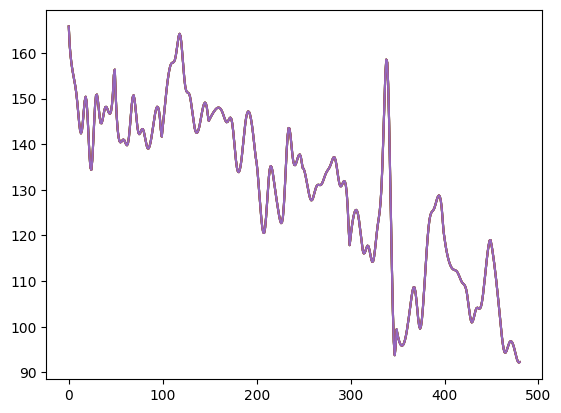

In [24]:
for i in range(5):
    true_observation, true_params = get_true_observation(hours = 24)
    
    # move to cpu
    true_observation = true_observation.cpu()
    
    plt.plot(true_observation)

In [25]:
def sample_from_posterior(posterior: Distribution, x_true: np.ndarray, num_samples: int = 1000) -> torch.Tensor: 
    x_true = torch.tensor(x_true, dtype=torch.float32, device=device)
    posterior_samples = posterior.sample((num_samples,), x=x_true)
    return posterior_samples

In [26]:
prior = process_uniform_priors(priors)

In [28]:
posterior_dist = run_TSNPE(prior = prior, simulator = sbi_simulator, true_observation = true_observation, num_rounds = 5, num_simulations = 1000)

Using device: cuda
Running round 1 of 5
Using pathos for parallel simulation.
Simulation took 218.81583070755005 sec.
 Training neural network. Epochs trained: 3

c:\Users\320264407\Glucose-Project\.venv\Lib\site-packages\sbi\inference\trainers\npe\npe_base.py:157: UserWarning: Data x has device 'cuda:0'. Moving x to the data_device 'cuda'. Training will proceed on device 'cuda'.
  theta, x = validate_theta_and_x(
c:\Users\320264407\Glucose-Project\.venv\Lib\site-packages\sbi\inference\trainers\npe\npe_base.py:157: UserWarning: Parameters theta has device 'cuda:0'. Moving theta to the data_device 'cuda'. Training will proceed on device 'cuda'.
  theta, x = validate_theta_and_x(


 Neural network successfully converged after 147 epochs.

Drawing 1000000 posterior samples: 1000017it [02:32, 6547.40it/s]                            


Running round 2 of 5
The `RestrictedPrior` rejected 85.1% of prior samples. You will get a speed-up of 570.8%.
Using pathos for parallel simulation.
Simulation took 217.12387537956238 sec.
 Training neural network. Epochs trained: 1

c:\Users\320264407\Glucose-Project\.venv\Lib\site-packages\sbi\inference\trainers\npe\npe_base.py:157: UserWarning: Data x has device 'cuda:0'. Moving x to the data_device 'cuda'. Training will proceed on device 'cuda'.
  theta, x = validate_theta_and_x(
c:\Users\320264407\Glucose-Project\.venv\Lib\site-packages\sbi\inference\trainers\npe\npe_base.py:157: UserWarning: Parameters theta has device 'cuda:0'. Moving theta to the data_device 'cuda'. Training will proceed on device 'cuda'.
  theta, x = validate_theta_and_x(


 Neural network successfully converged after 47 epochs.

Drawing 1000000 posterior samples: 1000231it [02:30, 6624.73it/s]                            


Running round 3 of 5
The `RestrictedPrior` rejected 96.0% of prior samples. You will get a speed-up of 2385.8%.
Using pathos for parallel simulation.
Simulation took 216.17594981193542 sec.
 Training neural network. Epochs trained: 1

c:\Users\320264407\Glucose-Project\.venv\Lib\site-packages\sbi\inference\trainers\npe\npe_base.py:157: UserWarning: Data x has device 'cuda:0'. Moving x to the data_device 'cuda'. Training will proceed on device 'cuda'.
  theta, x = validate_theta_and_x(
c:\Users\320264407\Glucose-Project\.venv\Lib\site-packages\sbi\inference\trainers\npe\npe_base.py:157: UserWarning: Parameters theta has device 'cuda:0'. Moving theta to the data_device 'cuda'. Training will proceed on device 'cuda'.
  theta, x = validate_theta_and_x(


 Neural network successfully converged after 65 epochs.

Drawing 1000000 posterior samples: 1000145it [02:29, 6686.06it/s]                            
                    accepted. It may take a long time to collect the remaining
                    -2 samples. Consider interrupting (Ctrl-C) and switching to
                    `sample_with='sir'`.


Running round 4 of 5
The `RestrictedPrior` rejected 99.4% of prior samples. You will get a speed-up of 16016.1%.
Using pathos for parallel simulation.
Simulation took 210.06410670280457 sec.


c:\Users\320264407\Glucose-Project\.venv\Lib\site-packages\sbi\inference\trainers\npe\npe_base.py:157: UserWarning: Data x has device 'cuda:0'. Moving x to the data_device 'cuda'. Training will proceed on device 'cuda'.
  theta, x = validate_theta_and_x(
c:\Users\320264407\Glucose-Project\.venv\Lib\site-packages\sbi\inference\trainers\npe\npe_base.py:157: UserWarning: Parameters theta has device 'cuda:0'. Moving theta to the data_device 'cuda'. Training will proceed on device 'cuda'.
  theta, x = validate_theta_and_x(


 Neural network successfully converged after 113 epochs.

Drawing 1000000 posterior samples: 1000042it [01:33, 10642.05it/s]                            


Running round 5 of 5


                    accepted. It may take a long time to collect the remaining
                    -3 samples. Consider interrupting (Ctrl-C) and switching to
                    `sample_with='sir'`.


The `RestrictedPrior` rejected 100.0% of prior samples. You will get a speed-up of 268195.1%.
Using pathos for parallel simulation.
Simulation took 206.55345392227173 sec.


c:\Users\320264407\Glucose-Project\.venv\Lib\site-packages\sbi\inference\trainers\npe\npe_base.py:157: UserWarning: Data x has device 'cuda:0'. Moving x to the data_device 'cuda'. Training will proceed on device 'cuda'.
  theta, x = validate_theta_and_x(
c:\Users\320264407\Glucose-Project\.venv\Lib\site-packages\sbi\inference\trainers\npe\npe_base.py:157: UserWarning: Parameters theta has device 'cuda:0'. Moving theta to the data_device 'cuda'. Training will proceed on device 'cuda'.
  theta, x = validate_theta_and_x(


 Neural network successfully converged after 120 epochs.

Drawing 1000000 posterior samples: 1000220it [01:13, 13529.59it/s]                            


In [29]:

samples = sample_from_posterior(posterior_dist, true_observation, num_samples = 1000)

C:\Users\320264407\AppData\Local\Temp\ipykernel_28252\1539181231.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_true = torch.tensor(x_true, dtype=torch.float32, device=device)
Drawing 1000 posterior samples: 1384it [00:00, 3959.58it/s]                        


In [77]:
import pickle

In [78]:
pickle.dump(samples, open('posterior_samples_TSNPE_5_1000.pkl', 'wb'))
pickle.dump(posterior_dist, open('posterior_dist_TSNPE_5_1000.pkl', 'wb'))

In [30]:
glucose_dynamics = run_glucose_simulator(samples, hours = 24)
glucose_dynamics = glucose_dynamics.cpu().numpy()
mean_glucose_dynamics = np.mean(glucose_dynamics, axis=0)
std_glucose_dynamics = np.std(glucose_dynamics, axis=0)

Using pathos for parallel simulation.
Simulation took 186.8429296016693 sec.


In [43]:
mse = mean_squared_error(true_observation.cpu().numpy(), mean_glucose_dynamics)
print(f'MSE: {mse}')

MSE: 30.42353630065918


In [58]:
parametric_mean = samples.mean(dim=0)
print(parametric_mean.shape)

# put the parametric mean into a higher order tensor
parametric_mean = parametric_mean.unsqueeze(0)

torch.Size([23])


In [75]:

glucose_dynamics_with_parametric_mean = run_glucose_simulator(parametric_mean, hours = 24)
glucose_dynamics_with_parametric_mean = glucose_dynamics_with_parametric_mean.cpu().numpy()[0]
mse_true_vs_parametric_mean = mean_squared_error(true_observation.cpu().numpy(), glucose_dynamics_with_parametric_mean)

Using pathos for parallel simulation.


In [71]:
print(glucose_dynamics_with_parametric_mean.shape)

(481,)


In [40]:
# an array of time as glucose_dynamics.shape[1]
timeline = np.arange(glucose_dynamics.shape[1])

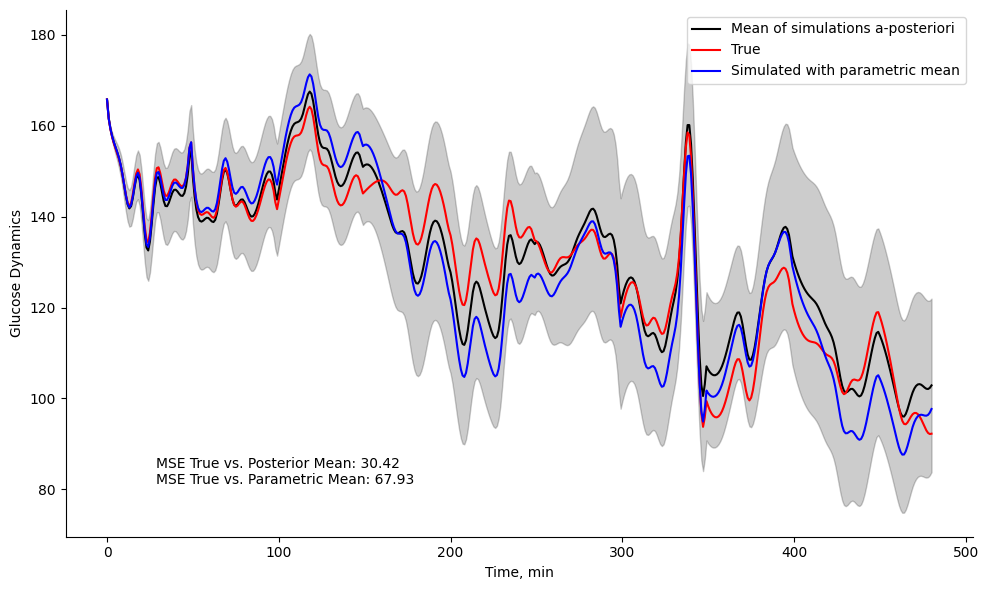

In [76]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(timeline, mean_glucose_dynamics, label='Mean of simulations a-posteriori', color = 'black')
ax.fill_between(timeline, mean_glucose_dynamics - std_glucose_dynamics, mean_glucose_dynamics + std_glucose_dynamics, alpha=0.2, color='black')
ax.plot(true_observation.cpu().numpy(), label='True', color = 'red')
ax.plot(glucose_dynamics_with_parametric_mean, label='Simulated with parametric mean', color = 'blue')
sns.despine()
ax.legend(loc = 'upper right')
ax.set_xlabel('Time, min')
ax.set_ylabel('Glucose Dynamics')
ax.text(0.1, 0.1, f'MSE True vs. Posterior Mean: {mse:.2f}\nMSE True vs. Parametric Mean: {mse_true_vs_parametric_mean:.2f}', transform=ax.transAxes)
plt.tight_layout()

In [90]:
long_simulation_true = get_true_observation(hours = 72)
long_simulation_posterior = run_glucose_simulator(samples, hours = 72)

Using pathos for parallel simulation.


In [95]:
print(long_simulation_true[0])
print(long_simulation_posterior.shape)

tensor([165.7939, 161.5820, 159.2394,  ..., 144.5941, 143.4804, 143.1301],
       device='cuda:0')
(1000, 1441)


In [96]:
#long_simulation_posterior = long_simulation_posterior.cpu().numpy()
mean_long_simulation_posterior = np.mean(long_simulation_posterior, axis=0)
std_long_simulation_posterior = np.std(long_simulation_posterior, axis=0)   

In [100]:
mse = mean_squared_error(long_simulation_true[0].cpu().numpy(), mean_long_simulation_posterior)
print(f'MSE: {mse}')

MSE: 34.19222640991211


In [97]:
timeline_long = np.arange(long_simulation_posterior.shape[1])   

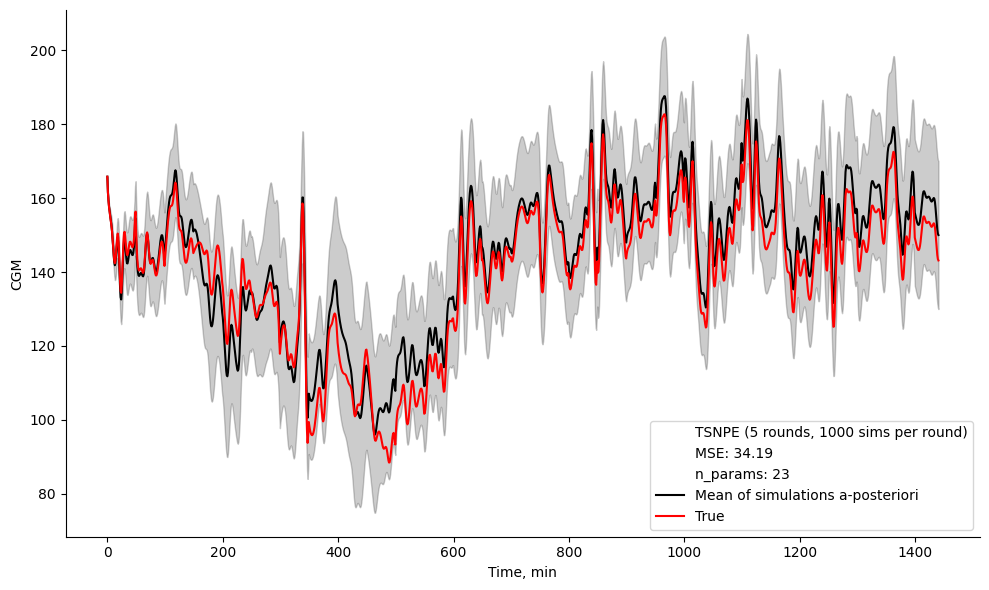

In [109]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(0, 100, s=0, label=f'TSNPE (5 rounds, 1000 sims per round)')
ax.scatter(0, 100, s=0, label=f'MSE: {mse:.2f}')
ax.scatter(0, 100, s=0, label=f'n_params: {len(fields(ParamPriors))}')
ax.plot(timeline_long, mean_long_simulation_posterior, label='Mean of simulations a-posteriori', color = 'black')
ax.fill_between(timeline_long, mean_long_simulation_posterior - std_long_simulation_posterior, mean_long_simulation_posterior + std_long_simulation_posterior, alpha=0.2, color='black')
ax.plot(timeline_long, long_simulation_true[0].cpu().numpy(), label='True', color = 'red')
sns.despine()

ax.set_xlabel('Time, min')
ax.set_ylabel('CGM')
#ax.text(0.1, 0.1, f'MSE: {mse:.2f}', transform=ax.transAxes)

ax.legend(loc = 'lower right')
plt.tight_layout()

In [111]:
posterior_dist = run_TSNPE(prior = prior, simulator = sbi_simulator, true_observation = true_observation, num_rounds = 5, num_simulations = 2000)

Using device: cuda
Running round 1 of 5
Using pathos for parallel simulation.


c:\Users\320264407\Glucose-Project\.venv\Lib\site-packages\sbi\inference\trainers\npe\npe_base.py:157: UserWarning: Data x has device 'cuda:0'. Moving x to the data_device 'cuda'. Training will proceed on device 'cuda'.
  theta, x = validate_theta_and_x(
c:\Users\320264407\Glucose-Project\.venv\Lib\site-packages\sbi\inference\trainers\npe\npe_base.py:157: UserWarning: Parameters theta has device 'cuda:0'. Moving theta to the data_device 'cuda'. Training will proceed on device 'cuda'.
  theta, x = validate_theta_and_x(


 Neural network successfully converged after 114 epochs.

Drawing 1000000 posterior samples: 1000223it [02:13, 7496.84it/s]                            


Running round 2 of 5
The `RestrictedPrior` rejected 94.8% of prior samples. You will get a speed-up of 1836.4%.
Using pathos for parallel simulation.


c:\Users\320264407\Glucose-Project\.venv\Lib\site-packages\sbi\inference\trainers\npe\npe_base.py:157: UserWarning: Data x has device 'cuda:0'. Moving x to the data_device 'cuda'. Training will proceed on device 'cuda'.
  theta, x = validate_theta_and_x(
c:\Users\320264407\Glucose-Project\.venv\Lib\site-packages\sbi\inference\trainers\npe\npe_base.py:157: UserWarning: Parameters theta has device 'cuda:0'. Moving theta to the data_device 'cuda'. Training will proceed on device 'cuda'.
  theta, x = validate_theta_and_x(


 Neural network successfully converged after 73 epochs.

Drawing 1000000 posterior samples: 1000346it [01:33, 10749.25it/s]                            
                    accepted. It may take a long time to collect the remaining
                    945 samples. Consider interrupting (Ctrl-C) and switching to
                    `sample_with='sir'`.


Running round 3 of 5
The `RestrictedPrior` rejected 99.3% of prior samples. You will get a speed-up of 15026.5%.
Using pathos for parallel simulation.


c:\Users\320264407\Glucose-Project\.venv\Lib\site-packages\sbi\inference\trainers\npe\npe_base.py:157: UserWarning: Data x has device 'cuda:0'. Moving x to the data_device 'cuda'. Training will proceed on device 'cuda'.
  theta, x = validate_theta_and_x(
c:\Users\320264407\Glucose-Project\.venv\Lib\site-packages\sbi\inference\trainers\npe\npe_base.py:157: UserWarning: Parameters theta has device 'cuda:0'. Moving theta to the data_device 'cuda'. Training will proceed on device 'cuda'.
  theta, x = validate_theta_and_x(


 Neural network successfully converged after 121 epochs.

Drawing 1000000 posterior samples: 1000570it [01:00, 16563.05it/s]                            


Running round 4 of 5


                    accepted. It may take a long time to collect the remaining
                    999 samples. Consider interrupting (Ctrl-C) and switching to
                    `sample_with='sir'`.


The `RestrictedPrior` rejected 100.0% of prior samples. You will get a speed-up of 463000.0%.
Using pathos for parallel simulation.


c:\Users\320264407\Glucose-Project\.venv\Lib\site-packages\sbi\inference\trainers\npe\npe_base.py:157: UserWarning: Data x has device 'cuda:0'. Moving x to the data_device 'cuda'. Training will proceed on device 'cuda'.
  theta, x = validate_theta_and_x(
c:\Users\320264407\Glucose-Project\.venv\Lib\site-packages\sbi\inference\trainers\npe\npe_base.py:157: UserWarning: Parameters theta has device 'cuda:0'. Moving theta to the data_device 'cuda'. Training will proceed on device 'cuda'.
  theta, x = validate_theta_and_x(


 Neural network successfully converged after 154 epochs.

Drawing 1000000 posterior samples: 1000587it [00:51, 19272.74it/s]                            


Running round 5 of 5


                    accepted. It may take a long time to collect the remaining
                    999 samples. Consider interrupting (Ctrl-C) and switching to
                    `sample_with='sir'`.


The `RestrictedPrior` rejected 100.0% of prior samples. You will get a speed-up of 30106000.0%.
Using pathos for parallel simulation.


c:\Users\320264407\Glucose-Project\.venv\Lib\site-packages\sbi\inference\trainers\npe\npe_base.py:157: UserWarning: Data x has device 'cuda:0'. Moving x to the data_device 'cuda'. Training will proceed on device 'cuda'.
  theta, x = validate_theta_and_x(
c:\Users\320264407\Glucose-Project\.venv\Lib\site-packages\sbi\inference\trainers\npe\npe_base.py:157: UserWarning: Parameters theta has device 'cuda:0'. Moving theta to the data_device 'cuda'. Training will proceed on device 'cuda'.
  theta, x = validate_theta_and_x(


 Neural network successfully converged after 197 epochs.

Drawing 1000000 posterior samples: 1000198it [00:37, 26374.83it/s]                            


In [112]:
samples = sample_from_posterior(posterior_dist, true_observation, num_samples = 1000)

C:\Users\320264407\AppData\Local\Temp\ipykernel_28252\1539181231.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_true = torch.tensor(x_true, dtype=torch.float32, device=device)
Drawing 1000 posterior samples: 1225it [00:00, 3435.42it/s]                         


In [132]:
pickle.dump(samples, open('posterior_samples_TSNPE_5_2000.pkl', 'wb'))
pickle.dump(posterior_dist, open('posterior_dist_TSNPE_5_2000.pkl', 'wb'))

In [113]:
glucose_dynamics = run_glucose_simulator(samples, hours = 24)

Using pathos for parallel simulation.


In [116]:
glucose_dynamics = glucose_dynamics.cpu().numpy()

In [117]:
print(glucose_dynamics.shape)

(1000, 481)


In [126]:
mean_glucose_dynamics = np.mean(glucose_dynamics, axis=0)
std_glucose_dynamics = np.std(glucose_dynamics, axis=0)

In [122]:
mse = mean_squared_error(true_observation.cpu().numpy(), mean_glucose_dynamics)
print(f'MSE: {mse}')

MSE: 11.39512825012207


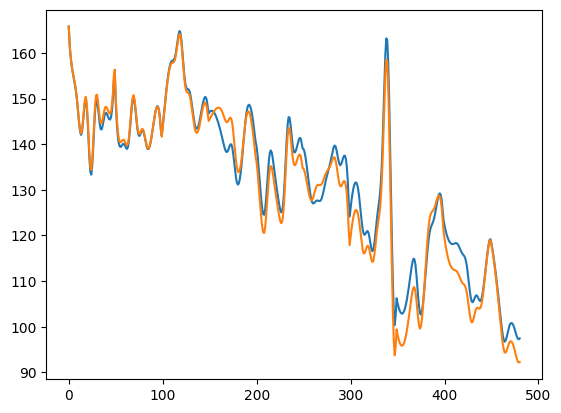

In [128]:
plt.plot(mean_glucose_dynamics)
plt.plot(true_observation.cpu().numpy())

In [124]:
long_simulation_posterior = run_glucose_simulator(samples, hours = 72)
mean_long_simulation_posterior = np.mean(long_simulation_posterior.cpu().numpy(), axis=0)

Using pathos for parallel simulation.


In [129]:
std_long_simulation_posterior = np.std(long_simulation_posterior.cpu().numpy(), axis=0)

In [130]:
mse = mean_squared_error(long_simulation_true[0].cpu().numpy(), mean_long_simulation_posterior)

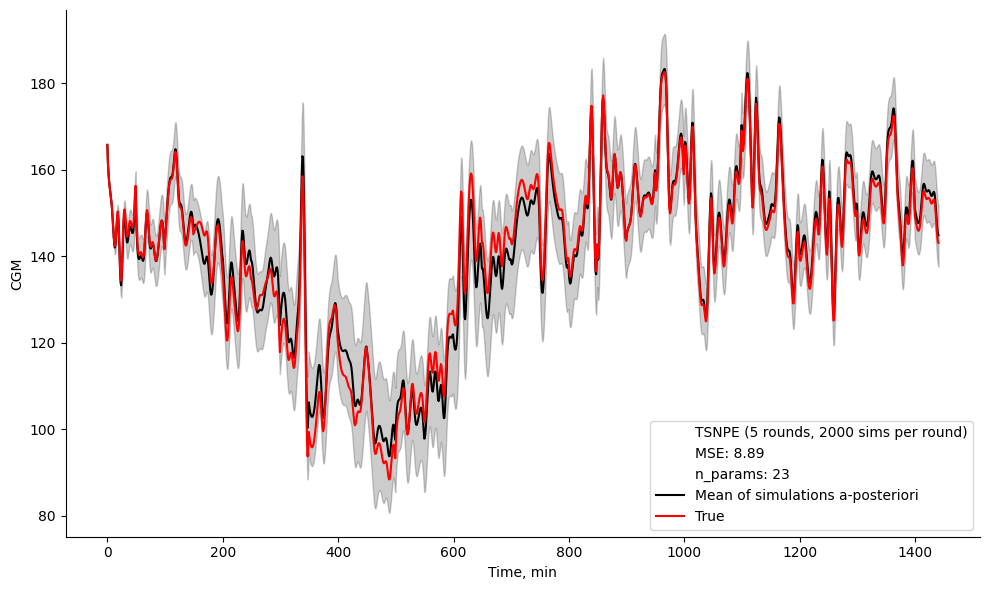

In [131]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(0, 100, s=0, label=f'TSNPE (5 rounds, 2000 sims per round)')
ax.scatter(0, 100, s=0, label=f'MSE: {mse:.2f}')
ax.scatter(0, 100, s=0, label=f'n_params: {len(fields(ParamPriors))}')
ax.plot(timeline_long, mean_long_simulation_posterior, label='Mean of simulations a-posteriori', color = 'black')
ax.fill_between(timeline_long, mean_long_simulation_posterior - std_long_simulation_posterior, mean_long_simulation_posterior + std_long_simulation_posterior, alpha=0.2, color='black')
ax.plot(timeline_long, long_simulation_true[0].cpu().numpy(), label='True', color = 'red')
sns.despine()

ax.set_xlabel('Time, min')
ax.set_ylabel('CGM')
#ax.text(0.1, 0.1, f'MSE: {mse:.2f}', transform=ax.transAxes)

ax.legend(loc = 'lower right')
plt.tight_layout()

In [148]:
@dataclass
class DeafultSimulationEnv:
   patient_name: str = 'adolescent#002'
   sensor_name: str = 'Dexcom'
   pump_name: str = 'Insulet'
   scenario: list[tuple[int,int]] = field(default_factory=lambda: [(7, 45), (12, 70), (16, 15), (18, 80), (23, 10)])
   hours: int = 24  # hours to simulate

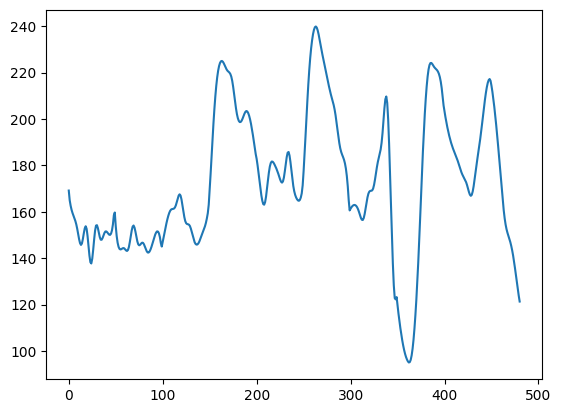

In [149]:
true_observation, true_params = get_true_observation(hours = 24)
plt.plot(true_observation.cpu().numpy())

In [151]:
posterior_dist = run_TSNPE(prior = prior, simulator = sbi_simulator, true_observation = true_observation, num_rounds = 5, num_simulations = 5000)

Using device: cuda
Running round 1 of 5
Using pathos for parallel simulation.


c:\Users\320264407\Glucose-Project\.venv\Lib\site-packages\sbi\inference\trainers\npe\npe_base.py:157: UserWarning: Data x has device 'cuda:0'. Moving x to the data_device 'cuda'. Training will proceed on device 'cuda'.
  theta, x = validate_theta_and_x(
c:\Users\320264407\Glucose-Project\.venv\Lib\site-packages\sbi\inference\trainers\npe\npe_base.py:157: UserWarning: Parameters theta has device 'cuda:0'. Moving theta to the data_device 'cuda'. Training will proceed on device 'cuda'.
  theta, x = validate_theta_and_x(


 Neural network successfully converged after 320 epochs.

Drawing 1000000 posterior samples: 1000215it [01:23, 11979.66it/s]                            


Running round 2 of 5
The `RestrictedPrior` rejected 98.5% of prior samples. You will get a speed-up of 6404.5%.
Using pathos for parallel simulation.


c:\Users\320264407\Glucose-Project\.venv\Lib\site-packages\sbi\inference\trainers\npe\npe_base.py:157: UserWarning: Data x has device 'cuda:0'. Moving x to the data_device 'cuda'. Training will proceed on device 'cuda'.
  theta, x = validate_theta_and_x(
c:\Users\320264407\Glucose-Project\.venv\Lib\site-packages\sbi\inference\trainers\npe\npe_base.py:157: UserWarning: Parameters theta has device 'cuda:0'. Moving theta to the data_device 'cuda'. Training will proceed on device 'cuda'.
  theta, x = validate_theta_and_x(


 Neural network successfully converged after 227 epochs.

Drawing 1000000 posterior samples: 1000199it [00:54, 18319.72it/s]                            


Running round 3 of 5


                    accepted. It may take a long time to collect the remaining
                    3998 samples. Consider interrupting (Ctrl-C) and switching to
                    `sample_with='sir'`.


The `RestrictedPrior` rejected 100.0% of prior samples. You will get a speed-up of 236270.9%.
Using pathos for parallel simulation.


c:\Users\320264407\Glucose-Project\.venv\Lib\site-packages\sbi\inference\trainers\npe\npe_base.py:157: UserWarning: Data x has device 'cuda:0'. Moving x to the data_device 'cuda'. Training will proceed on device 'cuda'.
  theta, x = validate_theta_and_x(
c:\Users\320264407\Glucose-Project\.venv\Lib\site-packages\sbi\inference\trainers\npe\npe_base.py:157: UserWarning: Parameters theta has device 'cuda:0'. Moving theta to the data_device 'cuda'. Training will proceed on device 'cuda'.
  theta, x = validate_theta_and_x(


 Neural network successfully converged after 55 epochs.

Drawing 1000000 posterior samples: 1000459it [01:00, 16411.11it/s]                            


Running round 4 of 5


                    accepted. It may take a long time to collect the remaining
                    3999 samples. Consider interrupting (Ctrl-C) and switching to
                    `sample_with='sir'`.


The `RestrictedPrior` rejected 100.0% of prior samples. You will get a speed-up of 933400.0%.
Using pathos for parallel simulation.


c:\Users\320264407\Glucose-Project\.venv\Lib\site-packages\sbi\inference\trainers\npe\npe_base.py:157: UserWarning: Data x has device 'cuda:0'. Moving x to the data_device 'cuda'. Training will proceed on device 'cuda'.
  theta, x = validate_theta_and_x(
c:\Users\320264407\Glucose-Project\.venv\Lib\site-packages\sbi\inference\trainers\npe\npe_base.py:157: UserWarning: Parameters theta has device 'cuda:0'. Moving theta to the data_device 'cuda'. Training will proceed on device 'cuda'.
  theta, x = validate_theta_and_x(


 Neural network successfully converged after 28 epochs.

Drawing 1000000 posterior samples: 1000285it [01:00, 16569.44it/s]                            


Running round 5 of 5


                    accepted. It may take a long time to collect the remaining
                    3999 samples. Consider interrupting (Ctrl-C) and switching to
                    `sample_with='sir'`.


The `RestrictedPrior` rejected 100.0% of prior samples. You will get a speed-up of 4339000.0%.
Using pathos for parallel simulation.


c:\Users\320264407\Glucose-Project\.venv\Lib\site-packages\sbi\inference\trainers\npe\npe_base.py:157: UserWarning: Data x has device 'cuda:0'. Moving x to the data_device 'cuda'. Training will proceed on device 'cuda'.
  theta, x = validate_theta_and_x(
c:\Users\320264407\Glucose-Project\.venv\Lib\site-packages\sbi\inference\trainers\npe\npe_base.py:157: UserWarning: Parameters theta has device 'cuda:0'. Moving theta to the data_device 'cuda'. Training will proceed on device 'cuda'.
  theta, x = validate_theta_and_x(


 Neural network successfully converged after 81 epochs.

Drawing 1000000 posterior samples: 1000251it [00:49, 20346.92it/s]                            


In [156]:
samples = sample_from_posterior(posterior_dist, true_observation, num_samples = 1000)


C:\Users\320264407\AppData\Local\Temp\ipykernel_28252\1539181231.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_true = torch.tensor(x_true, dtype=torch.float32, device=device)
Drawing 1000 posterior samples: 1261it [00:00, 3050.89it/s]                         


In [170]:
pickle.dump(samples, open('posterior_samples_adolescent2_TSNPE_5_5000.pkl', 'wb'))
pickle.dump(posterior_dist, open('posterior_dist_adolescent2_TSNPE_5_5000.pkl', 'wb'))

In [157]:
glucose_dynamics = run_glucose_simulator(samples, hours = 24)

Using pathos for parallel simulation.


In [161]:
mean_glucose_dynamics = np.mean(glucose_dynamics.cpu().numpy(), axis=0)
std_glucose_dynamics = np.std(glucose_dynamics.cpu().numpy(), axis=0)

In [159]:
mse = mean_squared_error(true_observation.cpu().numpy(), mean_glucose_dynamics)
print(f'MSE: {mse}')

MSE: 235.41195678710938


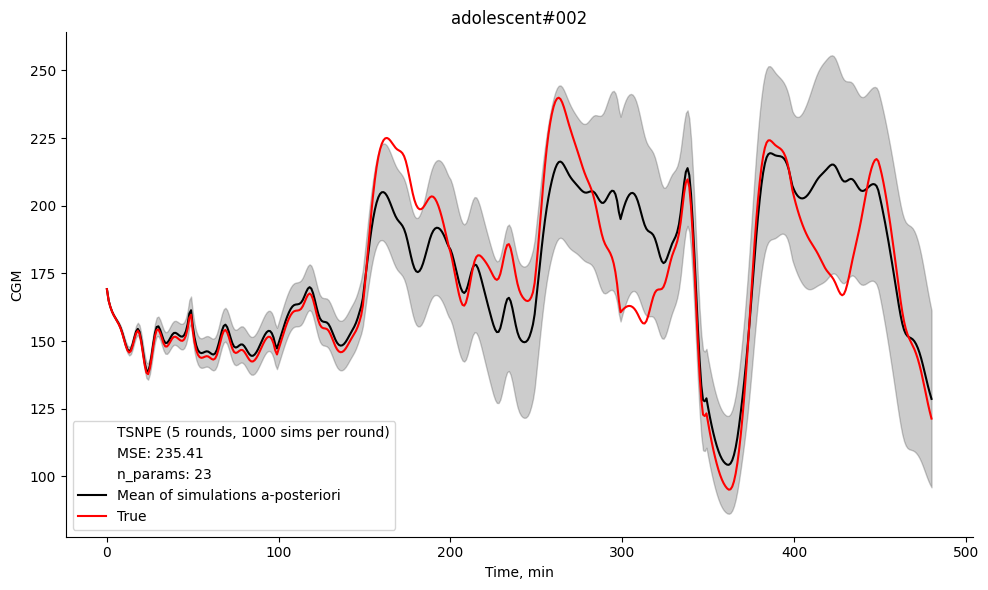

In [168]:
#timeline = np.arange(mean_glucose_dynamics.shape[1])
fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(0, 100, s=0, label=f'TSNPE (5 rounds, 1000 sims per round)')
ax.scatter(0, 100, s=0, label=f'MSE: {mse:.2f}')
ax.scatter(0, 100, s=0, label=f'n_params: {len(fields(ParamPriors))}')
ax.plot(timeline, mean_glucose_dynamics, label='Mean of simulations a-posteriori', color = 'black')
ax.fill_between(timeline, mean_glucose_dynamics - std_glucose_dynamics, mean_glucose_dynamics + std_glucose_dynamics, alpha=0.2, color='black')
ax.plot(timeline, true_observation.cpu().numpy(), label='True', color = 'red')
sns.despine()

ax.set_xlabel('Time, min')
ax.set_ylabel('CGM')
#ax.text(0.1, 0.1, f'MSE: {mse:.2f}', transform=ax.transAxes)

ax.legend(loc = 'lower left')
plt.title('adolescent#002')
plt.tight_layout()